# Stage 1: Comprehensive 3D Molecular Feature Extraction

This notebook extracts all available three-dimensional molecular descriptors from RDKit that capture spatial arrangement, conformational flexibility, and geometric properties that may better correlate with mass spectral fragmentation patterns.

## Pipeline Overview:

### Responsibilities:
1. **Load Raw Spectral Data**: Read JSONL files containing SMILES and peak data
2. **Generate 3D Conformers**: Use ETKDGv3 for improved conformer generation
3. **Extract Comprehensive 3D Features**:
   - Principal Moments of Inertia (PMI) and derived descriptors
   - Shape descriptors (Asphericity, Eccentricity, PBF, etc.)
   - 3D Autocorrelation (AUTOCORR3D) - 80 descriptors
   - Radial Distribution Function (RDF) - 210 descriptors
   - 3D-MoRSE descriptors - 224 descriptors
   - WHIM descriptors - 114 descriptors
   - GETAWAY descriptors - 273 descriptors
   - USR and USRCAT shape descriptors
4. **Aggregate Features**: Combine features across multiple conformers
5. **Analyze Feature Importance**: Quick Random Forest analysis
6. **Save Intermediate Data**: Store processed data for Stage 2

### Why 3D Features Matter:

Mass spectrometry fragmentation is influenced by:
- **Molecular Shape**: Compact vs. extended conformations affect collision cross-sections
- **Electronic Distribution**: 3D charge distribution influences fragmentation pathways
- **Steric Effects**: Spatial hindrance affects bond breaking preferences
- **Conformational Flexibility**: Multiple conformers may contribute to observed spectra

### Input:
- `data/input/{dataset_type}/spectral_data.jsonl`

### Output (to temporary directory):
- `data/tmp/{dataset_type}/raw_spectral_data_3d.jsonl` - Original spectral data
- `data/tmp/{dataset_type}/molecular_features_3d.jsonl` - Extracted 3D features
- `data/tmp/{dataset_type}/feature_importance_3d.json` - Feature importance analysis
- `data/tmp/{dataset_type}/dataset_metadata_3d.json` - Dataset statistics
- `data/tmp/{dataset_type}/dataset_config_3d.json` - Configuration metadata
- `data/tmp/{dataset_type}/corrupted_3d_records.jsonl` - Error log

## 1. Environment Setup

Import all required libraries including RDKit 3D modules for conformer generation and descriptor calculation.

In [1]:
# Standard library imports
import os
import json
import warnings
import logging
import random
import traceback
from collections import defaultdict

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import psutil

# Machine learning imports for feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# RDKit imports
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Descriptors3D
from rdkit.Chem import rdMolDescriptors

# Configure warnings and logging
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Environment setup complete")
print("RDKit version:", Chem.rdBase.rdkitVersion)
print("=" * 60)

Environment setup complete
RDKit version: 2025.03.2


## 2. Configuration

Configuration specific to Stage 1: 3D molecular feature extraction.

**Key Configuration Sections:**
- `dataset_type`: Specifies which dataset to process
- `3d_features`: Conformer generation and descriptor settings
- `feature_analysis`: Random Forest settings for feature importance
- `processing`: Parallel processing and error handling settings

In [2]:
# Stage 1 Configuration
STAGE1_CONFIG = {
    # Dataset configuration
    'dataset_type': 'hpj',  # Change this to process different datasets
    
    # Paths configuration
    'paths': {
        'data_root': '../data',
        'input_dir': lambda dtype: f"../data/input/{dtype}",
        'input_file': lambda dtype: f"../data/input/{dtype}/spectral_data.jsonl",
        'temp_dir': lambda dtype: f"../data/tmp/{dtype}",  # Intermediate storage
        'corrupted_output': lambda dtype: f"../data/tmp/{dtype}/corrupted_3d_records.jsonl"
    },
    
    # Processing configuration
    'processing': {
        'n_jobs': -1,  # Use all available cores
        'error_log_detail_level': 'standard'
    },
    
    # 3D Feature extraction settings
    '3d_features': {
        'conformer_generation': {
            'method': 'ETKDGv3',
            'num_conformers': 5,
            'max_attempts': 100,
            'prune_rms_thresh': 0.5,
            'use_random_coords': True,
            'enforce_chirality': True,
            'num_threads': 0,  # Use all available
            'random_seed': 42
        },
        'descriptors': {
            # Basic 3D shape descriptors from Descriptors3D module
            'basic_3d': True,  # PMI, NPR, shape descriptors, etc.
            
            # Advanced 3D descriptors from rdMolDescriptors
            'autocorr3d': True,  # 3D autocorrelation (80 descriptors)
            'rdf': True,  # Radial Distribution Function (210 descriptors)
            'morse': True,  # 3D-MoRSE (224 descriptors)
            'whim': True,  # WHIM descriptors (114 descriptors)
            'getaway': True,  # GETAWAY descriptors (273 descriptors)
            
            # Shape recognition descriptors
            'usr': True,  # Ultrafast Shape Recognition (12 descriptors)
            'usr_cat': True,  # USR with pharmacophoric info (60 descriptors)
            
            # Custom atom properties for some descriptors
            'custom_atom_property': '',  # Empty string uses default properties
            'getaway_precision': 2.0,
            'whim_threshold': 0.001
        },
        'aggregation': 'mean'  # How to aggregate multi-conformer descriptors
    },
    
    # Feature importance analysis
    'feature_analysis': {
        'rf_estimators': 50,  # Quick RF for feature importance
        'rf_max_depth': 10,
        'rf_min_samples_split': 10,
        'sample_size': 5000,  # Max samples for feature analysis
        'plot_top_features': 20,
        'random_state': 42,
        'transform_sqrt': True  # Apply sqrt transform to targets
    },
    
    # Spectral processing for feature importance (minimal config)
    'spectral': {
        'bin_size': 1.0,
        'max_mz': 499
    }
}

print(f"Configuration loaded for dataset: {STAGE1_CONFIG['dataset_type']}")
print("=" * 60)

Configuration loaded for dataset: hpj


## 3. Directory Setup

Create necessary directories for intermediate data storage.

In [3]:
def setup_directories(dataset_type):
    """Create all necessary directories for Stage 1."""
    temp_dir = STAGE1_CONFIG['paths']['temp_dir'](dataset_type)
    os.makedirs(temp_dir, exist_ok=True)
    logger.info(f"Created directory: {temp_dir}")
    return temp_dir

# Setup directories
print("Setting up directories...")
dataset_type = STAGE1_CONFIG['dataset_type']
temp_dir = setup_directories(dataset_type)
print(f"Temporary directory: {temp_dir}")
print("Directory setup complete")
print("=" * 60)

2025-06-23 09:47:06,087 - INFO - Created directory: ../data/tmp/hpj


Setting up directories...
Temporary directory: ../data/tmp/hpj
Directory setup complete


## 4. Utility Functions

Core utilities for memory monitoring, data loading, and spectral processing.

In [4]:
# ---------------------- Utilities ---------------------- #
class Utilities:
    @staticmethod
    def get_memory_usage():
        """Get current memory usage in MB."""
        process = psutil.Process(os.getpid())
        mem_info = process.memory_info()
        return f"{mem_info.rss / (1024 * 1024):.1f} MB (RSS), {process.memory_percent():.1f}% of total"

    @staticmethod
    def convert_np_to_list(item):
        """Recursively convert numpy arrays to lists for JSON serialization."""
        if isinstance(item, np.ndarray):
            return item.tolist()
        elif isinstance(item, dict):
            return {k: Utilities.convert_np_to_list(v) for k, v in item.items()}
        elif isinstance(item, list):
            return [Utilities.convert_np_to_list(v) for v in item]
        else:
            return item

# Helper functions
def load_raw_spectral_data(filepath):
    """Load raw spectral data from JSONL file."""
    data = {}
    with open(filepath, 'r') as f:
        for line in tqdm(f, desc="Loading spectral data"):
            try:
                record = json.loads(line)
                smiles = record.get("smiles")
                peaks = record.get("peaks", [])
                if smiles and peaks:
                    data[smiles] = peaks
            except Exception as e:
                continue
    return data

def process_spectrum_to_binned(peaks, bin_size, max_mz):
    """Convert peak list to binned spectrum for feature importance analysis."""
    num_bins = int(max_mz / bin_size) + 1
    binned_spectrum = np.zeros(num_bins)
    
    for mz, intensity in peaks:
        if mz <= max_mz:
            bin_idx = int(mz / bin_size)
            binned_spectrum[bin_idx] = max(binned_spectrum[bin_idx], intensity)
    
    # Normalize
    max_intensity = np.max(binned_spectrum)
    if max_intensity > 0:
        binned_spectrum /= max_intensity
    
    return binned_spectrum

print("Utility functions loaded")
print(f"Initial memory usage: {Utilities.get_memory_usage()}")
print("=" * 60)

Utility functions loaded
Initial memory usage: 284.4 MB (RSS), 0.2% of total


## 5. 3D Feature Extraction Functions

Comprehensive 3D feature extraction functions utilizing all available RDKit 3D descriptors.

### Key 3D Descriptors:

**1. Basic Shape Descriptors (Descriptors3D module):**
- Principal Moments of Inertia (PMI1, PMI2, PMI3)
- Normalized Principal Moments Ratios (NPR1, NPR2)
- Asphericity, Eccentricity, InertialShapeFactor, SpherocityIndex
- RadiusOfGyration
- Plane of Best Fit (PBF)

**2. Advanced 3D Descriptors (rdMolDescriptors module):**
- **AUTOCORR3D**: 3D autocorrelation (80 descriptors)
- **RDF**: Radial Distribution Function (210 descriptors)
- **MORSE**: 3D-Molecule Representation of Structures based on Electron diffraction (224 descriptors)
- **WHIM**: Weighted Holistic Invariant Molecular descriptors (114 descriptors)
- **GETAWAY**: GEometry, Topology, and Atom-Weights AssemblY (273 descriptors)

**3. Shape Recognition Descriptors:**
- **USR**: Ultrafast Shape Recognition (12 descriptors)
- **USRCAT**: USR with pharmacophoric information (60 descriptors)

In [5]:
def generate_conformers(mol, num_conformers=5, max_attempts=100, prune_rms_thresh=0.5, 
                       enforce_chirality=True, random_seed=42):
    """Generate 3D conformers for a molecule."""
    try:
        # Add hydrogens
        mol = Chem.AddHs(mol)
        
        # Set up parameters for ETKDGv3
        params = AllChem.ETKDGv3()
        params.randomSeed = random_seed
        params.numThreads = 0  # Use all available
        params.pruneRmsThresh = prune_rms_thresh
        params.enforceChirality = enforce_chirality
        
        # Generate conformers
        conf_ids = AllChem.EmbedMultipleConfs(
            mol, 
            numConfs=num_conformers,
            params=params
        )
        
        if len(conf_ids) == 0:
            # Try single conformer with more attempts
            result = AllChem.EmbedMolecule(
                mol, 
                maxAttempts=max_attempts,
                randomSeed=random_seed
            )
            if result < 0:
                return None
            conf_ids = [0]
        
        # Optimize conformers with MMFF
        AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0)
        
        return mol, conf_ids
        
    except Exception as e:
        return None


def calculate_basic_3d_descriptors(mol, conf_id):
    """Calculate basic 3D descriptors from Descriptors3D module."""
    descriptors = {}
    
    try:
        # PMI descriptors
        descriptors['PMI1'] = Descriptors3D.PMI1(mol, confId=conf_id)
        descriptors['PMI2'] = Descriptors3D.PMI2(mol, confId=conf_id)
        descriptors['PMI3'] = Descriptors3D.PMI3(mol, confId=conf_id)
        
        # NPR ratios
        descriptors['NPR1'] = Descriptors3D.NPR1(mol, confId=conf_id)
        descriptors['NPR2'] = Descriptors3D.NPR2(mol, confId=conf_id)
        
        # Shape descriptors
        descriptors['Asphericity'] = Descriptors3D.Asphericity(mol, confId=conf_id)
        descriptors['Eccentricity'] = Descriptors3D.Eccentricity(mol, confId=conf_id)
        descriptors['InertialShapeFactor'] = Descriptors3D.InertialShapeFactor(mol, confId=conf_id)
        descriptors['SpherocityIndex'] = Descriptors3D.SpherocityIndex(mol, confId=conf_id)
        
        # Size descriptor
        descriptors['RadiusOfGyration'] = Descriptors3D.RadiusOfGyration(mol, confId=conf_id)
        
        # Plane of best fit
        descriptors['PBF'] = Descriptors3D.PBF(mol, confId=conf_id)
        
    except Exception as e:
        # Return zeros if calculation fails
        for key in ['PMI1', 'PMI2', 'PMI3', 'NPR1', 'NPR2', 'Asphericity', 
                   'Eccentricity', 'InertialShapeFactor', 'SpherocityIndex',
                   'RadiusOfGyration', 'PBF']:
            descriptors[key] = 0.0
    
    return descriptors


def calculate_autocorr3d(mol, conf_id, custom_property=''):
    """Calculate 3D autocorrelation descriptors (80 descriptors)."""
    try:
        autocorr = rdMolDescriptors.CalcAUTOCORR3D(mol, confId=conf_id, 
                                                  customAtomProperty=custom_property)
        return {'AUTOCORR3D': list(autocorr)}
    except:
        return {'AUTOCORR3D': [0.0] * 80}


def calculate_rdf(mol, conf_id, custom_property=''):
    """Calculate Radial Distribution Function descriptors (210 descriptors)."""
    try:
        rdf = rdMolDescriptors.CalcRDF(mol, confId=conf_id, 
                                       customAtomProperty=custom_property)
        return {'RDF': list(rdf)}
    except:
        return {'RDF': [0.0] * 210}


def calculate_morse(mol, conf_id, custom_property=''):
    """Calculate 3D-MoRSE descriptors (224 descriptors)."""
    try:
        morse = rdMolDescriptors.CalcMORSE(mol, confId=conf_id, 
                                          customAtomProperty=custom_property)
        return {'MORSE': list(morse)}
    except:
        return {'MORSE': [0.0] * 224}


def calculate_whim(mol, conf_id, threshold=0.001, custom_property=''):
    """Calculate WHIM descriptors (114 descriptors)."""
    try:
        whim = rdMolDescriptors.CalcWHIM(mol, confId=conf_id, 
                                        thresh=threshold,
                                        customAtomProperty=custom_property)
        return {'WHIM': list(whim)}
    except:
        return {'WHIM': [0.0] * 114}


def calculate_getaway(mol, conf_id, precision=2.0, custom_property=''):
    """Calculate GETAWAY descriptors (273 descriptors)."""
    try:
        getaway = rdMolDescriptors.CalcGETAWAY(mol, confId=conf_id, 
                                              precision=precision,
                                              customAtomProperty=custom_property)
        return {'GETAWAY': list(getaway)}
    except:
        return {'GETAWAY': [0.0] * 273}


def calculate_usr(mol, conf_id):
    """Calculate USR (Ultrafast Shape Recognition) descriptors (12 descriptors)."""
    try:
        usr = rdMolDescriptors.GetUSR(mol, confId=conf_id)
        return {'USR': list(usr)}
    except:
        return {'USR': [0.0] * 12}


def calculate_usr_cat(mol, conf_id):
    """Calculate USRCAT descriptors (60 descriptors)."""
    try:
        # USRCAT uses pharmacophoric points
        # We'll use default atom selections if not specified
        usr_cat = rdMolDescriptors.GetUSRCAT(mol, confId=conf_id)
        return {'USRCAT': list(usr_cat)}
    except:
        return {'USRCAT': [0.0] * 60}


def aggregate_descriptors(descriptor_list, aggregation='mean'):
    """Aggregate descriptors from multiple conformers."""
    if len(descriptor_list) == 1:
        # Single conformer - just flatten
        return flatten_descriptor_dict(descriptor_list[0])
    
    # Multiple conformers - aggregate
    aggregated = {}
    
    # Get all keys from first conformer
    for key in descriptor_list[0].keys():
        values_list = []
        
        for desc_dict in descriptor_list:
            if isinstance(desc_dict[key], list):
                values_list.append(desc_dict[key])
            else:
                values_list.append([desc_dict[key]])
        
        # Convert to numpy array for easier aggregation
        values_array = np.array(values_list)
        
        if aggregation == 'mean':
            aggregated[key] = np.mean(values_array, axis=0).tolist()
        elif aggregation == 'max':
            aggregated[key] = np.max(values_array, axis=0).tolist()
        elif aggregation == 'min':
            aggregated[key] = np.min(values_array, axis=0).tolist()
        elif aggregation == 'std':
            aggregated[key] = np.std(values_array, axis=0).tolist()
    
    return flatten_descriptor_dict(aggregated)


def flatten_descriptor_dict(desc_dict):
    """Flatten descriptor dictionary to a single array."""
    flattened = []
    
    # Order matters for consistency
    ordered_keys = ['PMI1', 'PMI2', 'PMI3', 'NPR1', 'NPR2', 'Asphericity',
                   'Eccentricity', 'InertialShapeFactor', 'SpherocityIndex',
                   'RadiusOfGyration', 'PBF', 'AUTOCORR3D', 'RDF', 'MORSE',
                   'WHIM', 'GETAWAY', 'USR', 'USRCAT']
    
    for key in ordered_keys:
        if key in desc_dict:
            value = desc_dict[key]
            if isinstance(value, list):
                flattened.extend(value)
            else:
                flattened.append(value)
    
    return np.array(flattened)


def extract_3d_features(smiles, config, error_log=None):
    """Extract all 3D features for a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            if error_log:
                with open(error_log, 'a') as f:
                    f.write(json.dumps({"error": "invalid SMILES", "smiles": smiles}) + "\n")
            return None
        
        # Get conformer generation settings
        conf_gen = config['3d_features']['conformer_generation']
        
        # Generate conformers
        result = generate_conformers(
            mol,
            num_conformers=conf_gen['num_conformers'],
            max_attempts=conf_gen['max_attempts'],
            prune_rms_thresh=conf_gen['prune_rms_thresh'],
            enforce_chirality=conf_gen['enforce_chirality'],
            random_seed=conf_gen['random_seed']
        )
        
        if result is None:
            if error_log:
                with open(error_log, 'a') as f:
                    f.write(json.dumps({"error": "conformer generation failed", "smiles": smiles}) + "\n")
            return None
        
        mol_3d, conf_ids = result
        
        # Get descriptor settings
        desc_config = config['3d_features']['descriptors']
        
        # Calculate descriptors for each conformer
        all_descriptors = []
        
        for conf_id in conf_ids:
            descriptors = {}
            
            # Basic 3D descriptors
            if desc_config.get('basic_3d', True):
                descriptors.update(calculate_basic_3d_descriptors(mol_3d, conf_id))
            
            # AUTOCORR3D
            if desc_config.get('autocorr3d', True):
                descriptors.update(calculate_autocorr3d(
                    mol_3d, conf_id, desc_config.get('custom_atom_property', '')
                ))
            
            # RDF
            if desc_config.get('rdf', True):
                descriptors.update(calculate_rdf(
                    mol_3d, conf_id, desc_config.get('custom_atom_property', '')
                ))
            
            # MORSE
            if desc_config.get('morse', True):
                descriptors.update(calculate_morse(
                    mol_3d, conf_id, desc_config.get('custom_atom_property', '')
                ))
            
            # WHIM
            if desc_config.get('whim', True):
                descriptors.update(calculate_whim(
                    mol_3d, conf_id, 
                    desc_config.get('whim_threshold', 0.001),
                    desc_config.get('custom_atom_property', '')
                ))
            
            # GETAWAY
            if desc_config.get('getaway', True):
                descriptors.update(calculate_getaway(
                    mol_3d, conf_id,
                    desc_config.get('getaway_precision', 2.0),
                    desc_config.get('custom_atom_property', '')
                ))
            
            # USR
            if desc_config.get('usr', True):
                descriptors.update(calculate_usr(mol_3d, conf_id))
            
            # USRCAT
            if desc_config.get('usr_cat', True):
                descriptors.update(calculate_usr_cat(mol_3d, conf_id))
            
            all_descriptors.append(descriptors)
        
        # Aggregate descriptors across conformers
        aggregated = aggregate_descriptors(
            all_descriptors, 
            config['3d_features']['aggregation']
        )
        
        return (smiles, aggregated)
        
    except Exception as e:
        if error_log:
            with open(error_log, 'a') as f:
                f.write(json.dumps({
                    "error": f"3D feature extraction failed: {str(e)}", 
                    "smiles": smiles,
                    "traceback": traceback.format_exc()
                }) + "\n")
        return None


def get_feature_names():
    """Get names for all features in the correct order."""
    names = []
    
    # Basic 3D descriptors
    names.extend(['PMI1', 'PMI2', 'PMI3', 'NPR1', 'NPR2', 'Asphericity',
                 'Eccentricity', 'InertialShapeFactor', 'SpherocityIndex',
                 'RadiusOfGyration', 'PBF'])
    
    # AUTOCORR3D (80 features)
    names.extend([f'AUTOCORR3D_{i}' for i in range(80)])
    
    # RDF (210 features)
    names.extend([f'RDF_{i}' for i in range(210)])
    
    # MORSE (224 features)
    names.extend([f'MORSE_{i}' for i in range(224)])
    
    # WHIM (114 features)
    names.extend([f'WHIM_{i}' for i in range(114)])
    
    # GETAWAY (273 features)
    names.extend([f'GETAWAY_{i}' for i in range(273)])
    
    # USR (12 features)
    names.extend([f'USR_{i}' for i in range(12)])
    
    # USRCAT (60 features)
    names.extend([f'USRCAT_{i}' for i in range(60)])
    
    return names


print("3D Feature extraction functions defined")
print(f"Total possible 3D features: {len(get_feature_names())}")
print("=" * 60)

3D Feature extraction functions defined
Total possible 3D features: 984


## 6. Execute Stage 1: 3D Feature Extraction

Load spectral data and extract comprehensive 3D molecular features.

In [6]:
print("STAGE 1: COMPREHENSIVE 3D FEATURE EXTRACTION")
print("=" * 60)

# Load raw spectral data
dataset_type = STAGE1_CONFIG['dataset_type']
input_path = STAGE1_CONFIG['paths']['input_file'](dataset_type)

if not os.path.exists(input_path):
    print(f"ERROR: Dataset '{dataset_type}' not found at {input_path}")
    print(f"Available datasets: {[d for d in os.listdir('../data/input') if os.path.isdir(os.path.join('../data/input', d))]}")
else:
    print(f"Loading raw spectral data from: {input_path}")
    raw_spectra = load_raw_spectral_data(input_path)
    print(f"Loaded {len(raw_spectra)} spectra")
    
    # Process spectra to binned format (for feature importance analysis)
    print("\nProcessing spectra to binned format for feature importance...")
    binned_spectra = {}
    for smiles, peaks in tqdm(raw_spectra.items(), desc="Binning spectra"):
        binned_spectra[smiles] = process_spectrum_to_binned(
            peaks, 
            STAGE1_CONFIG['spectral']['bin_size'],
            STAGE1_CONFIG['spectral']['max_mz']
        )
    
    print(f"Processed {len(binned_spectra)} spectra")
    print(f"Spectrum dimension: {binned_spectra[next(iter(binned_spectra))].shape[0]}")
    print("=" * 60)

STAGE 1: COMPREHENSIVE 3D FEATURE EXTRACTION
Loading raw spectral data from: ../data/input/hpj/spectral_data.jsonl


Loading spectral data: 2720it [00:00, 3226.03it/s]


Loaded 2720 spectra

Processing spectra to binned format for feature importance...


Binning spectra: 100%|██████████| 2720/2720 [00:00<00:00, 4286.96it/s]

Processed 2720 spectra
Spectrum dimension: 500


In [7]:
print("EXTRACTING COMPREHENSIVE 3D MOLECULAR FEATURES")
print("=" * 60)

# Setup error logging
error_log_path = STAGE1_CONFIG['paths']['corrupted_output'](dataset_type)

# Clear error log
with open(error_log_path, 'w') as f:
    pass

# Extract features from all SMILES
smiles_list = list(binned_spectra.keys())
print(f"Processing {len(smiles_list)} molecules with {STAGE1_CONFIG['processing']['n_jobs']} parallel jobs")
print(f"\nFeatures to extract:")
desc_config = STAGE1_CONFIG['3d_features']['descriptors']
print(f"  - Basic 3D descriptors: {desc_config.get('basic_3d', True)} (11 features)")
print(f"  - AUTOCORR3D: {desc_config.get('autocorr3d', True)} (80 features)")
print(f"  - RDF: {desc_config.get('rdf', True)} (210 features)")
print(f"  - MORSE: {desc_config.get('morse', True)} (224 features)")
print(f"  - WHIM: {desc_config.get('whim', True)} (114 features)")
print(f"  - GETAWAY: {desc_config.get('getaway', True)} (273 features)")
print(f"  - USR: {desc_config.get('usr', True)} (12 features)")
print(f"  - USRCAT: {desc_config.get('usr_cat', True)} (60 features)")
print(f"\nTotal features per molecule: {len(get_feature_names())}")
print("")

# Parallel processing using joblib
results = Parallel(n_jobs=STAGE1_CONFIG['processing']['n_jobs'])(
    delayed(extract_3d_features)(
        smi,
        STAGE1_CONFIG,
        error_log_path
    ) for smi in tqdm(smiles_list, desc="Extracting 3D features")
)

# Collect results
features_3d = []
targets = []
valid_smiles = []

for result in results:
    if result is not None:
        smi, feat = result
        features_3d.append(feat)
        targets.append(binned_spectra[smi])
        valid_smiles.append(smi)

# Convert to numpy arrays
X_3d = np.array(features_3d)
y = np.array(targets)

print(f"\nSuccessfully extracted features for {len(X_3d)}/{len(smiles_list)} molecules")
print(f"Failed: {len(smiles_list) - len(X_3d)} molecules")
print(f"\n3D Feature dimensions: {X_3d.shape[1]} features")
print(f"Target dimensions: {y.shape[1]} bins")

# Count failures
with open(error_log_path, 'r') as f:
    failure_count = sum(1 for _ in f)
print(f"\nFailure rate: {failure_count}/{len(smiles_list)} molecules ({failure_count/len(smiles_list)*100:.1f}%)")

# Analyze failure reasons
print("\nFailure Analysis:")
failure_reasons = {}
with open(error_log_path, 'r') as f:
    for line in f:
        error_data = json.loads(line)
        reason = error_data.get('error', 'unknown')
        if 'conformer generation failed' in reason:
            reason = 'conformer generation failed'
        elif '3D feature extraction failed' in reason:
            reason = '3D feature extraction failed'
        failure_reasons[reason] = failure_reasons.get(reason, 0) + 1

for reason, count in sorted(failure_reasons.items(), key=lambda x: x[1], reverse=True):
    print(f"  {reason}: {count} molecules")

print("=" * 60)

EXTRACTING COMPREHENSIVE 3D MOLECULAR FEATURES
Processing 2720 molecules with -1 parallel jobs

Features to extract:
  - Basic 3D descriptors: True (11 features)
  - AUTOCORR3D: True (80 features)
  - RDF: True (210 features)
  - MORSE: True (224 features)
  - WHIM: True (114 features)
  - GETAWAY: True (273 features)
  - USR: True (12 features)
  - USRCAT: True (60 features)

Total features per molecule: 984



Extracting 3D features: 100%|██████████| 2720/2720 [01:56<00:00, 23.40it/s]



Successfully extracted features for 2720/2720 molecules
Failed: 0 molecules

3D Feature dimensions: 984 features
Target dimensions: 500 bins

Failure rate: 0/2720 molecules (0.0%)

Failure Analysis:


## 7. Feature Importance Analysis

Use a quick Random Forest model to analyze feature importance of 3D descriptors.

FEATURE IMPORTANCE ANALYSIS
Total features: 984
Feature categories:
  - Basic 3D: 11 features
  - AUTOCORR3D: 80 features
  - RDF: 210 features
  - MORSE: 224 features
  - WHIM: 114 features
  - GETAWAY: 273 features
  - USR: 12 features
  - USRCAT: 60 features

Training Random Forest for feature importance...
Feature importance calculation complete

Importance by category:
  Basic 3D: 0.2245 (22.5%)
  AUTOCORR3D: 0.0000 (0.0%)
  RDF: 0.0000 (0.0%)
  MORSE: 0.0000 (0.0%)
  WHIM: 0.0000 (0.0%)
  GETAWAY: 0.0000 (0.0%)
  USR: 0.0511 (5.1%)
  USRCAT: 0.7244 (72.4%)


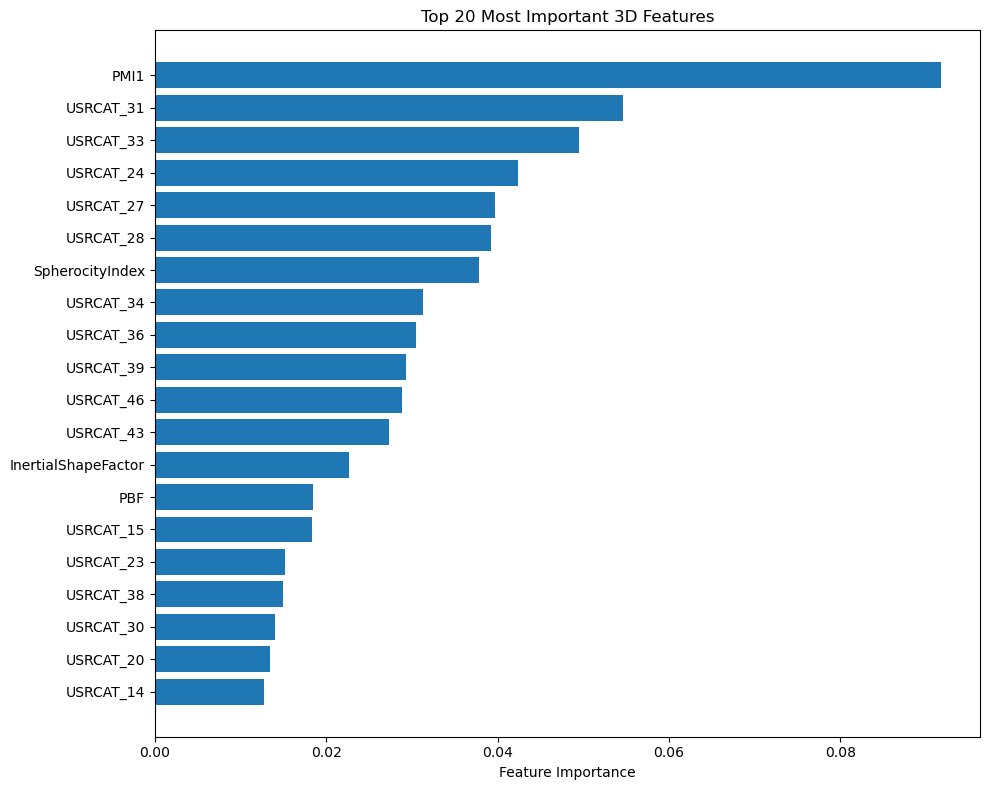

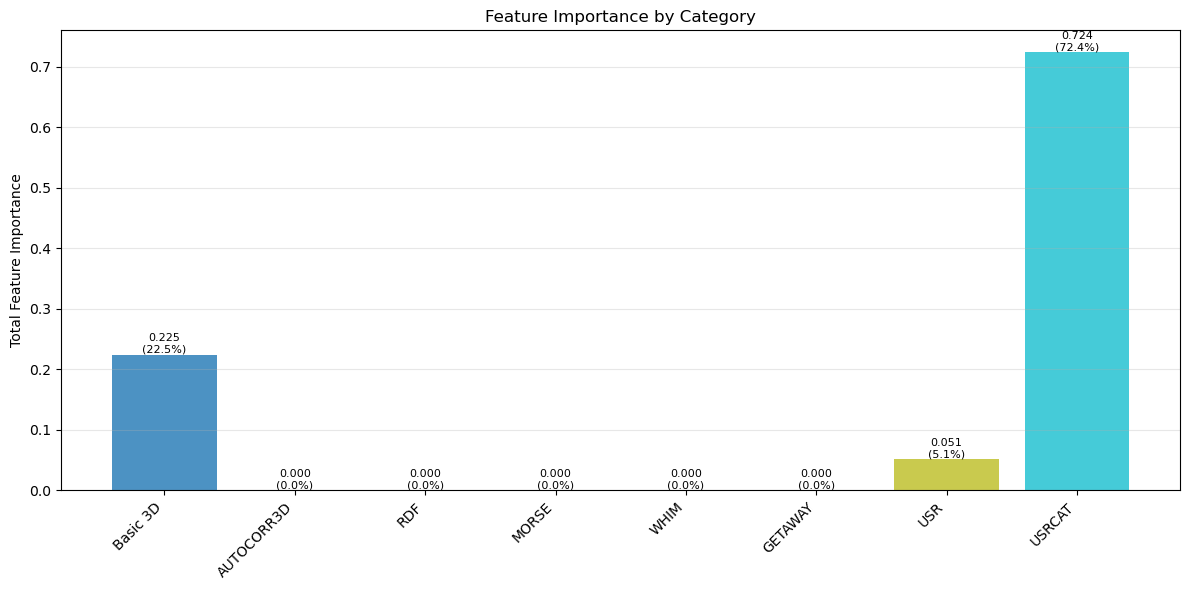


Top 10 Most Important Features:
 1. PMI1                 0.0917
 2. USRCAT_31            0.0547
 3. USRCAT_33            0.0495
 4. USRCAT_24            0.0424
 5. USRCAT_27            0.0397
 6. USRCAT_28            0.0393
 7. SpherocityIndex      0.0378
 8. USRCAT_34            0.0313
 9. USRCAT_36            0.0304
10. USRCAT_39            0.0293


In [8]:
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature names
feature_names = get_feature_names()

# Verify we have the right number of features
if X_3d.shape[1] != len(feature_names):
    print(f"WARNING: Feature count mismatch. Expected {len(feature_names)}, got {X_3d.shape[1]}")
    # Adjust feature names if needed
    feature_names = [f'Feature_{i}' for i in range(X_3d.shape[1])]

print(f"Total features: {len(feature_names)}")
print(f"Feature categories:")
print(f"  - Basic 3D: 11 features")
print(f"  - AUTOCORR3D: 80 features")
print(f"  - RDF: 210 features")
print(f"  - MORSE: 224 features")
print(f"  - WHIM: 114 features")
print(f"  - GETAWAY: 273 features")
print(f"  - USR: 12 features")
print(f"  - USRCAT: 60 features")

# Sample data for faster analysis
sample_size = min(STAGE1_CONFIG['feature_analysis']['sample_size'], len(X_3d))
if sample_size < len(X_3d):
    print(f"\nSampling {sample_size} molecules for feature importance analysis...")
    indices = np.random.choice(len(X_3d), sample_size, replace=False)
    X_sample = X_3d[indices]
    y_sample = y[indices]
else:
    X_sample = X_3d
    y_sample = y

# Apply transformation if configured
if STAGE1_CONFIG['feature_analysis']['transform_sqrt']:
    y_sample = np.sqrt(y_sample)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=STAGE1_CONFIG['feature_analysis']['random_state']
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle any NaN values
X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)

# Train quick RF for feature importance
print("\nTraining Random Forest for feature importance...")
rf_analyzer = RandomForestRegressor(
    n_estimators=STAGE1_CONFIG['feature_analysis']['rf_estimators'],
    max_depth=STAGE1_CONFIG['feature_analysis']['rf_max_depth'],
    min_samples_split=STAGE1_CONFIG['feature_analysis']['rf_min_samples_split'],
    random_state=STAGE1_CONFIG['feature_analysis']['random_state'],
    n_jobs=STAGE1_CONFIG['processing']['n_jobs']
)

rf_analyzer.fit(X_train_scaled, y_train)
print("Feature importance calculation complete")

# Get feature importances
feature_importance = rf_analyzer.feature_importances_

# Feature importance by category
categories = {
    'Basic 3D': (0, 11),
    'AUTOCORR3D': (11, 91),
    'RDF': (91, 301),
    'MORSE': (301, 525),
    'WHIM': (525, 639),
    'GETAWAY': (639, 912),
    'USR': (912, 924),
    'USRCAT': (924, 984)
}

print("\nImportance by category:")
category_importance = {}
for cat_name, (start, end) in categories.items():
    if end <= len(feature_importance):
        cat_importance = np.sum(feature_importance[start:end])
        category_importance[cat_name] = cat_importance
        print(f"  {cat_name}: {cat_importance:.4f} ({cat_importance/np.sum(feature_importance)*100:.1f}%)")

# Visualization
# Plot 1: Top features
top_n = STAGE1_CONFIG['feature_analysis']['plot_top_features']
top_features_idx = np.argsort(feature_importance)[-top_n:]

plt.figure(figsize=(10, 8))
plt.barh(range(top_n), feature_importance[top_features_idx])
plt.yticks(range(top_n), [feature_names[i] if i < len(feature_names) else f'Feature_{i}' 
                         for i in top_features_idx])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important 3D Features")
plt.tight_layout()
plt.show()

# Plot 2: Category comparison
if category_importance:
    plt.figure(figsize=(12, 6))
    categories_list = list(category_importance.keys())
    importances = list(category_importance.values())
    colors = plt.cm.tab10(np.linspace(0, 1, len(categories_list)))
    
    bars = plt.bar(categories_list, importances, color=colors, alpha=0.8)
    plt.ylabel('Total Feature Importance')
    plt.title('Feature Importance by Category')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, importance in zip(bars, importances):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{importance:.3f}\n({importance/sum(importances)*100:.1f}%)',
                 ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

# Get top 10 features
top_10_idx = np.argsort(feature_importance)[-10:]
print("\nTop 10 Most Important Features:")
for rank, idx in enumerate(top_10_idx[::-1], 1):
    if idx < len(feature_names):
        print(f"{rank:2d}. {feature_names[idx]:<20} {feature_importance[idx]:.4f}")

print("=" * 60)

## 8. Save Stage 1 Output

Save 3D features and metadata to temporary directory for Stage 2 processing.

In [9]:
print("SAVING STAGE 1 OUTPUT")
print("=" * 60)

# Save raw spectral data
temp_dir = STAGE1_CONFIG['paths']['temp_dir'](dataset_type)
raw_data_path = os.path.join(temp_dir, 'raw_spectral_data_3d.jsonl')

print("Saving raw spectral data...")
with open(raw_data_path, 'w') as f:
    for smiles in tqdm(valid_smiles, desc="Saving spectra"):
        record = {
            "smiles": smiles,
            "peaks": raw_spectra[smiles]
        }
        f.write(json.dumps(record) + "\n")
print(f"Saved {len(valid_smiles)} spectra to {raw_data_path}")

# Save 3D molecular features
features_path = os.path.join(temp_dir, 'molecular_features_3d.jsonl')

print("\nSaving 3D molecular features...")
with open(features_path, 'w') as f:
    for smiles, features in tqdm(zip(valid_smiles, X_3d), desc="Saving features", total=len(valid_smiles)):
        record = {
            "smiles": smiles,
            "features_3d": features.tolist(),
            "feature_names": feature_names
        }
        f.write(json.dumps(record) + "\n")
print(f"Saved {len(valid_smiles)} feature vectors to {features_path}")

# Save feature importance results
importance_path = os.path.join(temp_dir, 'feature_importance_3d.json')

importance_data = {
    "feature_names": feature_names,
    "feature_importance": feature_importance.tolist(),
    "category_importance": category_importance,
    "top_10_features": [
        {"name": feature_names[idx] if idx < len(feature_names) else f'Feature_{idx}', 
         "importance": float(feature_importance[idx])}
        for idx in np.argsort(feature_importance)[-10:][::-1]
    ],
    "total_molecules": len(smiles_list),
    "successful_extractions": len(valid_smiles),
    "failure_count": failure_count,
    "failure_rate": failure_count / len(smiles_list),
    "num_features": X_3d.shape[1],
    "num_targets": y.shape[1]
}

with open(importance_path, 'w') as f:
    json.dump(importance_data, f, indent=2)
print(f"\nSaved feature importance analysis to {importance_path}")

# Save dataset metadata
metadata_path = os.path.join(temp_dir, 'dataset_metadata_3d.json')

# Create a JSON-serializable version of the config
serializable_config = {}
for key, value in STAGE1_CONFIG.items():
    if key == 'paths':
        # Evaluate the lambda functions for the current dataset type
        serializable_config[key] = {
            'data_root': value['data_root'],
            'input_dir': value['input_dir'](dataset_type),
            'input_file': value['input_file'](dataset_type),
            'temp_dir': value['temp_dir'](dataset_type),
            'corrupted_output': value['corrupted_output'](dataset_type)
        }
    else:
        serializable_config[key] = value

metadata = {
    "dataset_type": dataset_type,
    "config": serializable_config,
    "statistics": {
        "total_molecules": len(smiles_list),
        "successful_3d": len(valid_smiles),
        "feature_dimension": X_3d.shape[1],
        "spectrum_dimension": y.shape[1],
        "failure_reasons": failure_reasons,
        "feature_breakdown": {
            "basic_3d": 11,
            "autocorr3d": 80,
            "rdf": 210,
            "morse": 224,
            "whim": 114,
            "getaway": 273,
            "usr": 12,
            "usr_cat": 60
        }
    }
}

with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Saved metadata to {metadata_path}")

# Save dataset configuration for Stage 2
config_path = os.path.join(temp_dir, 'dataset_config_3d.json')
with open(config_path, 'w') as f:
    json.dump({
        'dataset_type': dataset_type,
        'stage1_complete': True,
        'num_molecules': len(valid_smiles),
        'feature_dimension': X_3d.shape[1],
        'feature_names': feature_names,
        'feature_config': STAGE1_CONFIG['3d_features']
    }, f, indent=2)
print(f"Saved configuration to {config_path}")

print("\nAll Stage 1 data saved successfully!")
print(f"Output directory: {temp_dir}")
print(f"Memory usage: {Utilities.get_memory_usage()}")

# Clean up Stage 1 variables to free memory
del X_3d, y, features_3d, targets, binned_spectra, raw_spectra
print("\nStage 1 complete!")
print("=" * 60)

SAVING STAGE 1 OUTPUT
Saving raw spectral data...


Saving spectra: 100%|██████████| 2720/2720 [00:00<00:00, 7064.11it/s]


Saved 2720 spectra to ../data/tmp/hpj/raw_spectral_data_3d.jsonl

Saving 3D molecular features...


Saving features: 100%|██████████| 2720/2720 [00:00<00:00, 2900.40it/s]

Saved 2720 feature vectors to ../data/tmp/hpj/molecular_features_3d.jsonl

Saved feature importance analysis to ../data/tmp/hpj/feature_importance_3d.json
Saved metadata to ../data/tmp/hpj/dataset_metadata_3d.json
Saved configuration to ../data/tmp/hpj/dataset_config_3d.json

All Stage 1 data saved successfully!
Output directory: ../data/tmp/hpj
Memory usage: 657.0 MB (RSS), 0.5% of total

Stage 1 complete!


## 9. Stage 1 Summary

Summary of files created for Stage 2 processing.

In [ ]:
# Display generated files
print("\nSTAGE 1 OUTPUT FILES:")
print("=" * 60)

temp_dir = STAGE1_CONFIG['paths']['temp_dir'](STAGE1_CONFIG['dataset_type'])
if os.path.exists(temp_dir):
    files = sorted(os.listdir(temp_dir))
    for file in files:
        file_path = os.path.join(temp_dir, file)
        if os.path.isfile(file_path):
            size_mb = os.path.getsize(file_path) / (1024 * 1024)
            print(f"  - {file}: {size_mb:.2f} MB")

print("\nThese files will be used as input for Stage 2.")
print("Next: Run 02_3d_spectral_processing_ml_preparation.ipynb")
print("\n" + "=" * 60)
print("3D FEATURE EXTRACTION COMPLETE")
print("Total possible 3D features extracted: 984")
print("  - Basic 3D descriptors: 11")
print("  - AUTOCORR3D: 80")
print("  - RDF: 210")
print("  - MORSE: 224")
print("  - WHIM: 114")
print("  - GETAWAY: 273")
print("  - USR: 12")
print("  - USRCAT: 60")
print("=" * 60)


STAGE 1 OUTPUT FILES:
  - 3d_features.pkl: 10.96 MB
  - corrupted_3d_records.jsonl: 0.00 MB
  - corrupted_records.jsonl: 0.00 MB
  - dataset_config.json: 0.00 MB
  - dataset_config_3d.json: 0.02 MB
  - dataset_metadata_3d.json: 0.00 MB
  - feature_importance_3d.json: 0.03 MB
  - molecular_features.jsonl: 111.92 MB
  - molecular_features_3d.jsonl: 48.53 MB
  - raw_spectral_data.jsonl: 16.40 MB
  - raw_spectral_data_3d.jsonl: 7.40 MB

These files will be used as input for Stage 2.
Next: Run 02_3d_spectral_processing_ml_preparation.ipynb

3D FEATURE EXTRACTION COMPLETE
Total possible 3D features extracted: 984
  - Basic 3D descriptors: 11
  - AUTOCORR3D: 80
  - RDF: 210
  - MORSE: 224
  - WHIM: 114
  - GETAWAY: 273
  - USR: 12
  - USRCAT: 60


: 